<a href="https://colab.research.google.com/github/labibaa/Forecasting-Inflation/blob/main/Monthly_data_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import datetime
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

np.random.seed(234)
tf.random.set_seed(234)

In [ ]:
print(tf.__version__)


2.9.2


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving datasetf_1 - cpi_month.csv to datasetf_1 - cpi_month.csv


In [ ]:
monthly_raw = pd.read_csv('datasetf_1 - cpi_month.csv',parse_dates=True)
monthly_raw.shape

(118, 3)

In [ ]:
monthly_raw.head(10)

,Date,CPI,Inflation
0,01/01/2013,184.33,6.62
1,01/02/2013,184.79,7.84
2,01/03/2013,185.01,7.71
3,01/04/2013,185.13,8.37
4,01/05/2013,182.91,7.98
5,01/06/2013,184.04,8.05
6,01/07/2013,186.79,7.85
7,01/08/2013,189.44,7.39
8,01/09/2013,192.24,7.13
9,01/10/2013,194.01,7.03


In [ ]:
monthly_raw.dtypes



Date          object
CPI          float64
Inflation    float64
dtype: object

In [ ]:
monthly_raw.Date = pd.to_datetime(monthly_raw.Date)


In [ ]:
monthly_df=monthly_raw.copy(deep=False)
monthly_df.dtypes

Date         datetime64[ns]
CPI                 float64
Inflation           float64
dtype: object

In [ ]:
monthly_df.head(10)

,Date,CPI,Inflation
0,2013-01-01,184.33,6.62
1,2013-01-02,184.79,7.84
2,2013-01-03,185.01,7.71
3,2013-01-04,185.13,8.37
4,2013-01-05,182.91,7.98
5,2013-01-06,184.04,8.05
6,2013-01-07,186.79,7.85
7,2013-01-08,189.44,7.39
8,2013-01-09,192.24,7.13
9,2013-01-10,194.01,7.03


In [ ]:
monthly_df['Date']= pd.to_datetime(monthly_df['Date'], dayfirst=True)
monthly_df.head(15)

,Date,CPI,Inflation
0,2013-01-01,184.330,6.62
1,2013-01-02,184.790,7.84
2,2013-01-03,185.010,7.71
3,2013-01-04,185.130,8.37
4,2013-01-05,182.910,7.98
5,2013-01-06,184.040,8.05
6,2013-01-07,186.790,7.85
7,2013-01-08,189.440,7.39
8,2013-01-09,192.240,7.13
9,2013-01-10,194.010,7.03


In [ ]:
monthly_df.dtypes

Date         datetime64[ns]
CPI                 float64
Inflation           float64
dtype: object

In [ ]:
monthly_df['Date'].nunique()
monthly=monthly_df.copy()

118

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f33b88e5490>,
      dtype=object)

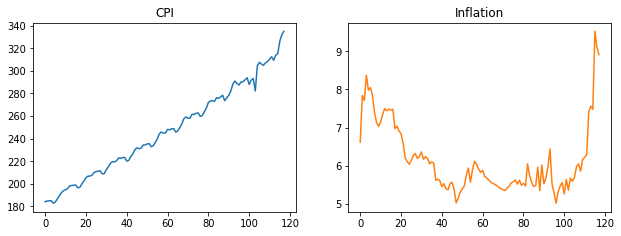

In [ ]:
#m2['CPI']=round((m2['CPI'].pct_change().fillna(0))*100,2)
monthly_df.iloc[:, 1:13].plot(kind='line',subplots=True,figsize=(16,16),title=['CPI','Inflation'],legend=False,layout=(4,3),
                       sharex=True,
                       )

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f33b8565b20>,
      dtype=object)

Text(0.5, 0.98, '10 Year Macroeconomic Indicators for Bangladesh')

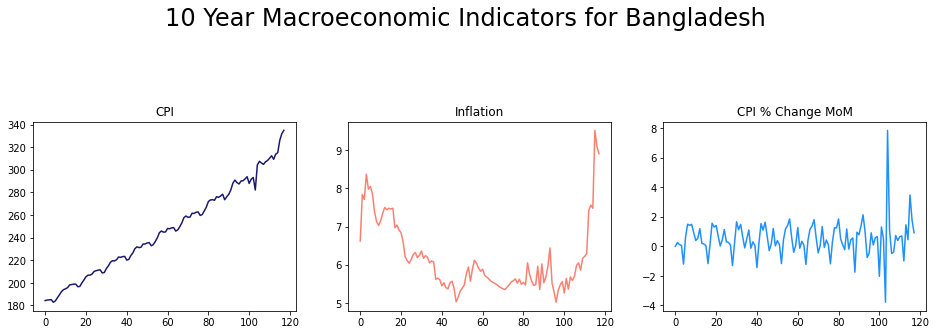

In [ ]:
monthly_df['cpi_pct_mom'] = round((monthly_df['CPI'].pct_change().fillna(0))*100,2)
monthly_df['cpi_pct_yoy'] = round((monthly_df['CPI'].pct_change(12).fillna(0))*100,2)

monthly_df.iloc[:, 1:4].plot(kind ='line',
            subplots = True,
            figsize = (16,16),
            title = ['CPI','Inflation','CPI % Change MoM'],
            legend = False,
            layout = (4,3),
            sharex = True,
            style = ['midnightblue', 'salmon', 'dodgerblue', ])

plt.suptitle('10 Year Macroeconomic Indicators for Bangladesh', fontsize = 24)

In [ ]:
monthly_raw.shape
monthly_raw.head(5)

(118, 3)

,Date,CPI,Inflation
0,2013-01-01,184.33,6.62
1,2013-01-02,184.79,7.84
2,2013-01-03,185.01,7.71
3,2013-01-04,185.13,8.37
4,2013-01-05,182.91,7.98


In [ ]:
df_cpi = monthly_raw.set_index('Date')


ValueError: ignored

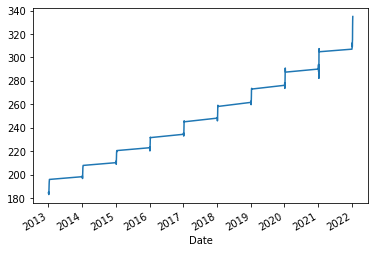

In [ ]:
df_cpi['CPI'].plot()
fig= seasonal_decompose(df_cpi['CPI'],model='additive').plot()

ValueError: ignored

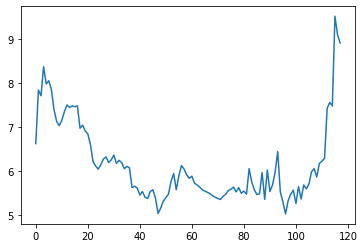

In [ ]:
monthly_df['Inflation'].plot()
fig= seasonal_decompose(monthly_df['Inflation'],model='additive').plot()

# Splitting Data


Training dataset: 106, Test dataset: 12


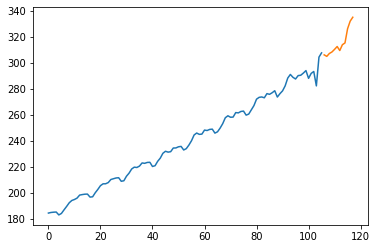

In [ ]:
split_point = len(monthly_df) - 12
train, test = monthly_df[0:split_point], monthly_df[split_point:]
print('Training dataset: %d, Test dataset: %d' % (len(train), len(test)))
train['CPI'].plot()
test['CPI'].plot()

Training dataset: 106, Test dataset: 12


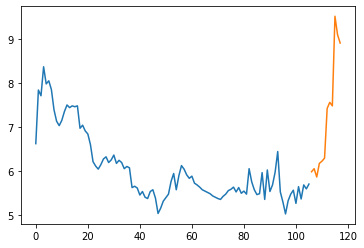

In [ ]:
split_point = len(monthly_df) - 12
train, test = monthly_df[0:split_point], monthly_df[split_point:]
print('Training dataset: %d, Test dataset: %d' % (len(train), len(test)))
train['Inflation'].plot()
test['Inflation'].plot()

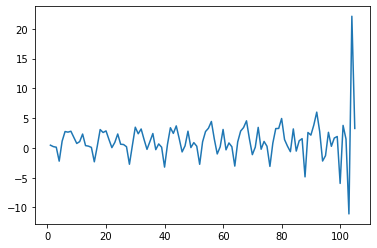

In [ ]:
diff = train['CPI'].diff()
plt.plot(diff)
plt.show()
diff = diff.dropna()

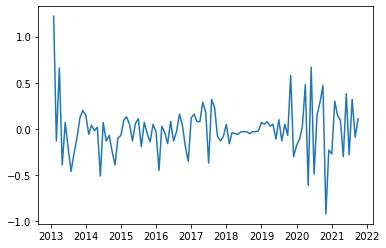

In [ ]:
diff = train['Inflation'].diff()
plt.plot(diff)
plt.show()
diff = diff.dropna()

#ADF Test

In [ ]:
def adf_test(df):
    result = adfuller(df.values)
    if result[1] > 0.05:
        print("Series is not stationary")
    else:
        print("Series is stationary")

adf_test(diff)

Series is not stationary


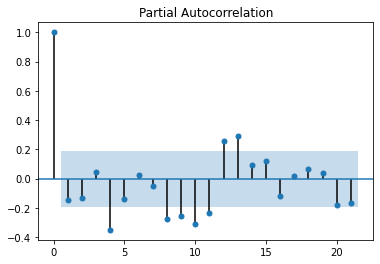

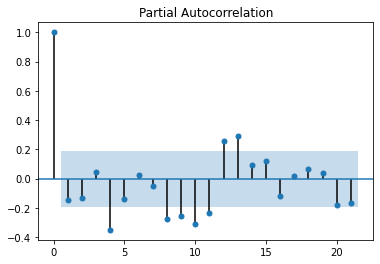

In [ ]:
plot_pacf(diff.values)


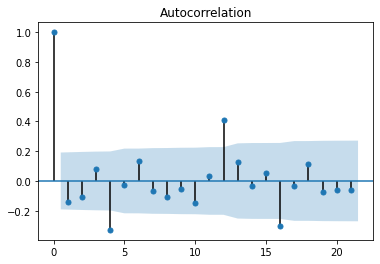

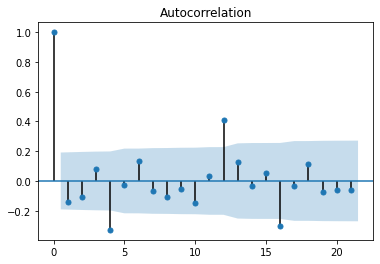

In [ ]:
plot_acf(diff.values)


# Univariate

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(monthly_df['CPI'].values.reshape(-1,1))

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
n_steps_in = 12

train, test = dataset[0:310], dataset[310:len(dataset),:]

trainX, trainY = split_sequence(train, n_steps_in)
testX, testY = split_sequence(test, n_steps_in)

In [ ]:
n_features = trainX.shape[2]

uni_model = Sequential()

# Adding the LSTM layer
uni_model.add(LSTM(64, input_shape=(trainX.shape[1], n_features)))

# Adding the output layer
uni_model.add(Dense(1))

uni_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = 'mean_squared_error', metrics=['mean_absolute_error'])

fit = uni_model.fit(trainX,
          trainY, validation_data = (testX, testY),
          epochs = 100, batch_size=3,
          verbose = 0)


# Check for overfitting
#plt.plot(fit.history['loss'], label = 'training', color = 'Blue')
#plt.plot(fit.history['val_loss'], label = 'validation', color = 'Red')
#plt.legend()
#plt.show

In [ ]:
trainPredict = uni_model.predict(trainX)
testPredict = uni_model.predict(testX)

Ytrain_hat = scaler.inverse_transform(trainPredict)
Ytrain_actual = scaler.inverse_transform(trainY)
Ytest_hat = scaler.inverse_transform(testPredict)
Ytest_actual = scaler.inverse_transform(testY)

4/4 [==============================] - 0s 20ms/step


ValueError: ignored

In [ ]:
trainScore = mean_squared_error(Ytrain_actual, Ytrain_hat[:,0])
print('Train Score: %.2f MSE' % (trainScore))
testScore = mean_squared_error(Ytest_actual, Ytest_hat[:,0])
print('Test Score: %.2f MSE' % (testScore))

model_error = Ytest_actual - Ytest_hat[:,0]
print('Mean Model Error: ', model_error.mean())

NameError: ignored

# Multivariate



In [ ]:
monthly_df_stationary = df_cpi.diff().dropna()
monthly_df_stationary = monthly_df_stationary.rename_axis('indicator', axis=1)
fig = px.line(monthly_df_stationary.iloc[:,0:10], facet_col="indicator", facet_col_wrap=1)
fig.update_yaxes(visible=False)


In [ ]:
maxlag=12
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):

    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(monthly_df_stationary, variables = monthly_df_stationary.columns)

,CPI_x,Inflation_x
CPI_y,1.0,0.0
Inflation_y,0.0,1.0


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

In [ ]:
scaled = scaler.fit_transform(df_cpi)


In [ ]:
scaled_df = pd.DataFrame(scaled, columns=df_cpi.columns, index=df_cpi.index)
scaled_df.head(5)

,CPI,Inflation
Date,,
2013-01-01,-1.576058,0.509682
2013-01-02,-1.564436,1.852050
2013-01-03,-1.558878,1.709011
2013-01-04,-1.555846,2.435210
2013-01-05,-1.611936,2.006093


In [ ]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        #find end of pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1

        #check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break

        #gather input and output
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix - 1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)

In [ ]:
#inputs
in_cpi = np.array(scaled_df.loc['2013-01-01':'2019-11-01', ['CPI']])
in_ur = np.array(scaled_df.loc['2013-01-01':'2019-11-01', ['Inflation']])


test_cpi = np.array(scaled_df.loc['2019-12-01':'2021-10-01', ['CPI']])
test_ur = np.array(scaled_df.loc['2019-12-01':'2021-10-01', ['Inflation']])


#output
trainoutput_cpi = in_cpi
testoutput_cpi = test_cpi


In [ ]:
in_cpi = in_cpi.reshape((len(in_cpi), 1))
in_ur = in_ur.reshape((len(in_ur), 1))


test_cpi = test_cpi.reshape((len(test_cpi), 1))
test_ur = test_ur.reshape((len(test_ur), 1))


trainoutput_cpi = trainoutput_cpi.reshape((len(trainoutput_cpi), 1))
testoutput_cpi = testoutput_cpi.reshape((len(testoutput_cpi), 1))

In [ ]:
trainset = np.hstack((in_cpi, in_ur,  trainoutput_cpi))
testset = np.hstack((test_cpi, test_ur, testoutput_cpi))

n_steps_in = 12
n_steps_out = 1

trainX, trainy = split_sequences(trainset, n_steps_in, n_steps_out)

testX, testy = split_sequences(testset, n_steps_in, n_steps_out)

trainX.shape, trainy.shape

((73, 12, 2), (73, 1))

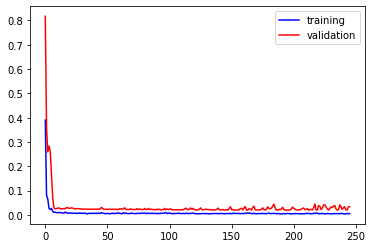

In [ ]:
n_features = trainX.shape[2]

multi_model = Sequential()

# Adding the LSTM layer and dropout regularizaiton
multi_model.add(LSTM(100, return_sequences = True, input_shape=(n_steps_in, n_features)))
multi_model.add(LSTM(100))
multi_model.add(Dropout(0.2))

# Adding output layer
multi_model.add(Dense(n_steps_out))

multi_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = 'mean_squared_error')

earlystop = EarlyStopping(monitor = 'val_loss', patience =50,
                  mode = 'min',
                  verbose = 0)

fit = multi_model.fit(trainX,
          trainy, validation_data = (testX, testy),
          epochs = 500, verbose=0, callbacks = [earlystop])


# Check for overfitting
plt.plot(fit.history['loss'], label = 'training', color = 'Blue')
plt.plot(fit.history['val_loss'], label = 'validation', color = 'Red')
plt.legend()
plt.show()

In [ ]:
def feature_importance(model, g):
    random_ind = np.random.choice(g.shape[0], 40, replace=False) # Randomly generate 40 numbers arange(218)
    x = g[random_ind] #  Take 40 random sample from training set
    orig_out = model.predict(x)
    for i in range(2):  # iterate over the  features
        new_x = x.copy()
        perturbation_in = np.random.normal(0.0, 0.7, size=new_x.shape[:2]) # Draw random samples from normal distribution with sd = 0.7, this value is arbitary and would not affect the order of effect as its just introducing noise.
        new_x[:,:, i] = new_x[:, :, i] + perturbation_in
        perturbed_out = model.predict(new_x)
        effect = ((orig_out - perturbed_out) ** 2).mean() ** 0.5
        print(f'Variable {i+1}, Perturbation Effect: {effect:.3f}')

feature_importance(multi_model,trainX)

2/2 [==============================] - 0s 8ms/step
Variable 1, Perturbation Effect: 0.193
2/2 [==============================] - 0s 9ms/step
Variable 2, Perturbation Effect: 0.038


In [ ]:
testPredict = multi_model.predict(testX)


1/1 [==============================] - 0s 28ms/step


In [ ]:
testX = testX.reshape((testX.shape[0], testX.shape[2]*testX.shape[1]))


In [ ]:
# Invert scaling for Predicted
testY_hat = np.concatenate((testX[:, 1:2], testPredict), axis=1)
testY_hat = scaler.inverse_transform(testY_hat)

testY_hat = testY_hat[:,1]

# Invert scaling for Actual
testY_actual = np.concatenate((testX[:,1:2], testy), axis=1)
testY_actual = scaler.inverse_transform(testY_actual)

testY_actual = testY_actual[:,1]

In [ ]:
mse = mean_squared_error(testY_actual, testY_hat)
print('Test MSE: %.3f' % mse)

model_error = testY_actual - testY_hat
print('Mean Model Error: ', model_error.mean())

Test MSE: 0.028
Mean Model Error:  -0.10930665795086868


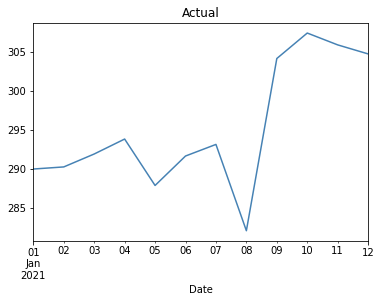

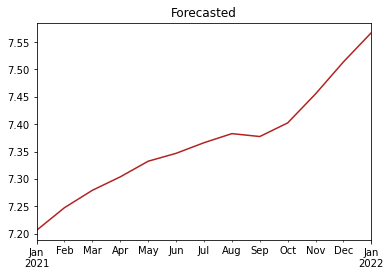

In [ ]:
observed = df_cpi.loc['2020-11-01':'2021-10-01',['CPI']]
observed.plot(color = 'SteelBlue', title = 'Actual', legend = False)
plt.show()

predicted = pd.DataFrame(testY_hat, index=pd.date_range('2021-01-01',periods=13,freq='M'))
predicted.plot(color = 'Firebrick', title = 'Forecasted', legend = False)
plt.show()

In [ ]:
x_input = np.array(scaled[-12:])
x_input = x_input.reshape((1, n_steps_in, n_features))

forecast_normalized = multi_model.predict(x_input)

# Manually inverse Min-max normalization
max_cpi = df_cpi['CPI'].max()
min_cpi = df_cpi['CPI'].min()
forecast =  max_cpi-forecast_normalized[0][0]/(max_cpi-min_cpi)
print('The CPI value for the month Nov 2021 predicted by LSTM is ', forecast)

#pct_chg = ((forecast - df_cpi.iloc[-12]['CPI'])/df_cpi.iloc[-12]['CPI']) * 100
#print('The forecasted Consumer Price Index (CPI) YoY is ' , round(pct_chg,2))

1/1 [==============================] - 0s 41ms/step
The CPI value for the month Nov 2021 predicted by LSTM is  334.88084331468775


In [ ]:
monthly_raw.head(110)

,Date,CPI,Inflation
0,2013-01-01,184.33,6.62
1,2013-01-02,184.79,7.84
2,2013-01-03,185.01,7.71
3,2013-01-04,185.13,8.37
4,2013-01-05,182.91,7.98
...,...,...,...
105,2021-01-10,307.49,5.70
106,2021-01-11,305.97,5.98
107,2021-01-12,304.81,6.05
108,2022-01-01,307.02,5.86
